# Problem 1: Bayesian Density Estimation
By: Griffin Hosseinzadeh (2025 May 6)  
Inspired by a notebook by LM Walkowicz (2019 June 14)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.visualization as viz
from scipy import stats
from sklearn.neighbors import KernelDensity

Here I'm simulating some data. Just run this cell to generate a list of values `x`.

In [22]:
x = np.concatenate([stats.cauchy(-5, 1.8).rvs(500),
                    stats.cauchy(-4, 0.8).rvs(2000),
                    stats.cauchy(-1, 0.3).rvs(500),
                    stats.cauchy(2, 0.8).rvs(1000),
                    stats.cauchy(4, 1.5).rvs(500)])

# truncate values to a reasonable range
x = x[(x > -15) & (x < 15)]

Make a histogram of these values using `plt.hist`. (Use `density=True` throughout this exercise, so the y-axes are comparable.) How many peaks does this data set have?

(array([0.0031077 , 0.00505002, 0.01825776, 0.12648353, 0.07070026,
        0.062931  , 0.03441782, 0.00877926, 0.0031077 , 0.0020977 ]),
 array([-14.95050097, -11.96482696,  -8.97915295,  -5.99347894,
         -3.00780493,  -0.02213091,   2.9635431 ,   5.94921711,
          8.93489112,  11.92056513,  14.90623915]),
 <BarContainer object of 10 artists>)

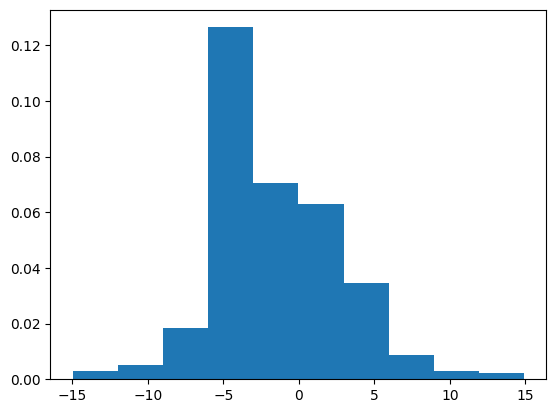

In [4]:
plt.hist(x,density=True)

Now make a histogram using the `'auto'` binning in Matplotlib. What does it think the right number of bins should be? How many peaks does this data set have?

43 bins


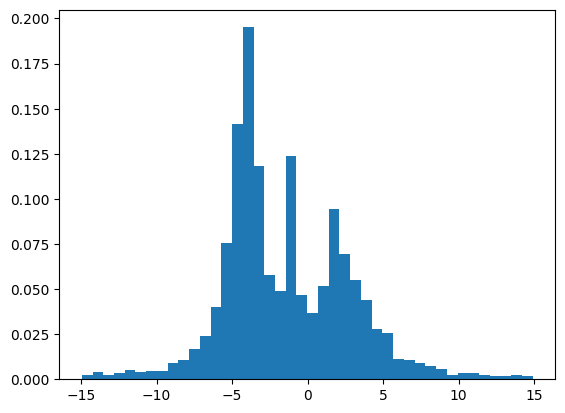

In [5]:
n, b, p = plt.hist(x,density=True, bins ='auto')
print(len(b), 'bins')

Increase the number of bins even further. Is there a point where it gets too high? If so, why?

The data has three peaks, it thinks 43 bins is the appropriate amount

(array([0.03884629, 0.        , 0.        , ..., 0.        , 0.        ,
        0.03884629], shape=(5000,)),
 array([-14.95050097, -14.94452963, -14.93855828, ...,  14.89429645,
         14.9002678 ,  14.90623915], shape=(5001,)),
 <BarContainer object of 5000 artists>)

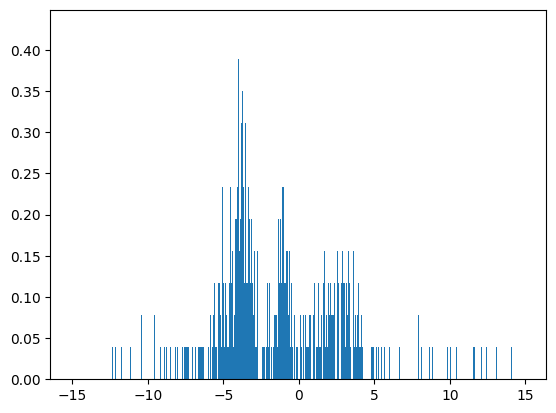

In [11]:
plt.hist(x,density=True, bins =5000)

The point where it starts to get too high is between 3000 and 5000 bins, the spacing makes the peaks very hard to read, and you can not get a good idea of the dirac delta values

Now make a histogram using Bayesian blocks. Hint: try the `astropy.visualization.hist` function. How many bins does this have? Can you see all the peaks?

16 bins


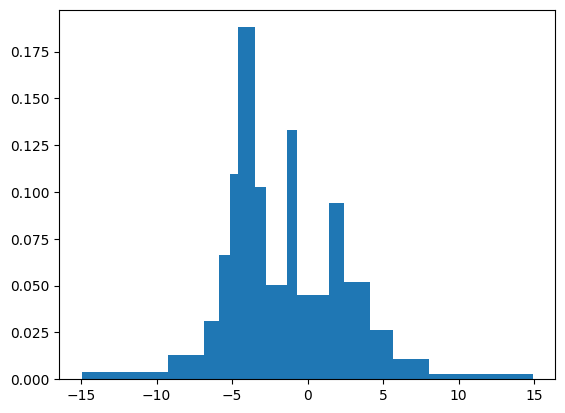

In [12]:
n, b, p = viz.hist(x, density=True, bins='blocks')
print(len(b), 'bins')

Try making the Bayesian blocks histogram *without* `density=True`. What do you notice? Is this a good idea?

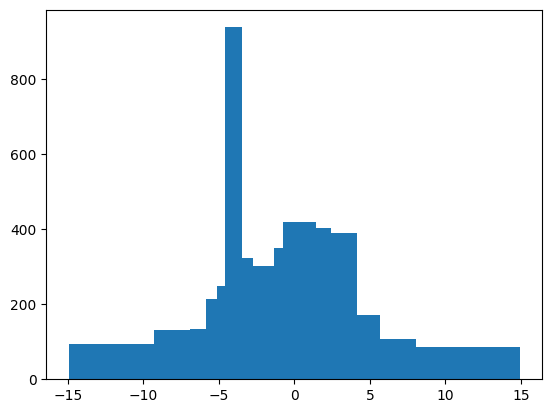

In [13]:
viz.hist(x, bins='blocks');

You lose the clarity of the original, you can not tell where the other two peaks are

Now let's try making a KDE instead. Try a few different values for the bandwidth until you find one you like.

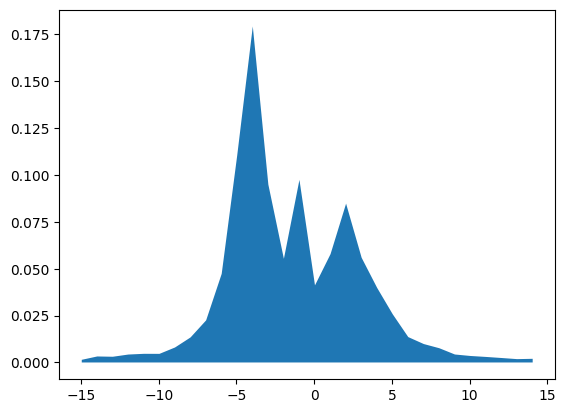

In [18]:
kde = KernelDensity(bandwidth=0.4,kernel='gaussian') 
kde.fit(x.reshape(-1,1))

x_fit = np.arange(min(x),max(x)) 
y_fit = np.exp(kde.score_samples(x_fit.reshape(-1,1)))
plt.fill_between(x_fit,y_fit)

Plot all of these density estimates on top of each other using `histtype='step'` and compare them.

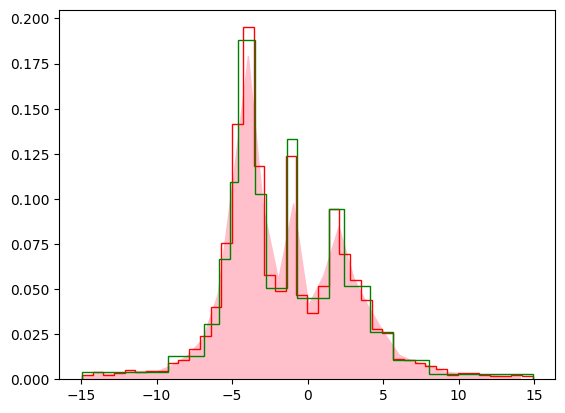

In [19]:
plt.fill_between(x_fit,y_fit , color= 'pink')
plt.hist(x, density=True,bins='auto',histtype='step',color='red')
n, b, p = viz.hist(x, density=True, bins='blocks',histtype='step',color='green')
# complete

# Problem 2: Gaussian Process Regression
By: Griffin Hosseinzadeh (2019 April 17)  
Updated 2025 May 6

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from astropy.table import Table
import pandas as pd

## Read the Light Curve
I have given you light curve data for the Type Ibn supernova PTF11rfh in the file `PTF11rfh.table`, which is readable with the `astropy.table` module. (Hint: `format='ascii.fixed_width'`.) For this example, let's fit the light curve in counts rather than magnitudes. Select only points observed in the $r$ or $R$ filter and have a measurement in counts. Plot it to see what we're working with. (For non-astronomers, MJD is a measure of time in days.)

In [49]:
data =  Table.read("PTF11rfh.table", format="ascii.fixed_width")

data_df = data.to_pandas()
data_df =  data_df[data_df['filt']=='R' ]
data_df =  data_df[~np.isnan(data_df['counts'])]

data= Table.from_pandas(data_df)
data

MJD,counts,dcounts,zp,nondet,filt,source,mag,dmag,limmag,flam,dflam
float64,float64,float64,float64,str5,str1,str3,float64,float64,float64,float64,float64
55889.091,19.7,36.8,27.0,True,R,P48,21.89257731651705,--,--,--,--
55889.125,22.2,45.1,27.0,True,R,P48,21.671755508505942,--,--,--,--
55889.167,-7.8,49.6,27.0,True,R,P48,21.56849267197535,--,--,--,--
55891.167,-17.1,54.8,27.0,True,R,P48,21.46024546698992,--,--,--,--
55892.099,99.8,107.9,27.0,True,R,P48,20.724643251493568,--,--,--,--
55892.142,-128.1,64.0,27.0,True,R,P48,21.291746928241125,--,--,--,--
55892.178,-13.6,107.1,27.0,True,R,P48,20.732723186121206,--,--,--,--
55893.098,-57.5,56.9,27.0,True,R,P48,21.419416197213167,--,--,--,--
55893.136,-85.3,64.3,27.0,True,R,P48,21.28666943089029,--,--,--,--


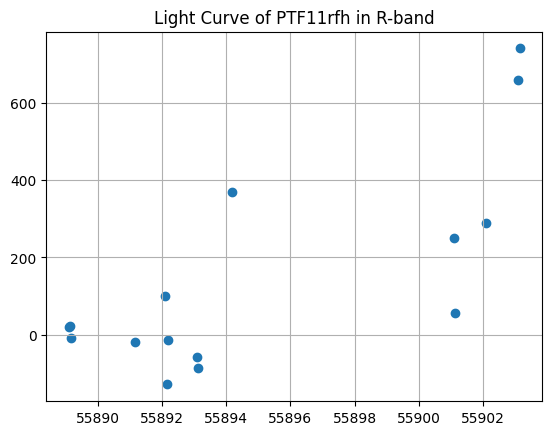

In [50]:
x = data['MJD']
y = data['counts']
dy = data['dcounts']
plt.scatter(x,y)
plt.title('Light Curve of PTF11rfh in R-band')
plt.grid(True)

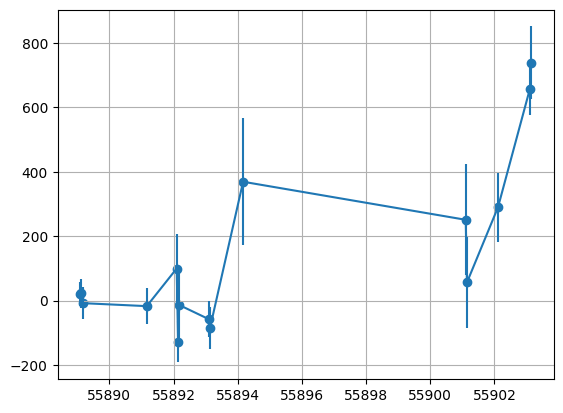

In [51]:
plt.scatter(x,y)
plt.errorbar(x,y,yerr=dy)
plt.grid(True)

## Try a Polynomial Fit
Hint: use `np.polyfit` and `np.polyval`. Try different degree polynomials to see if you are able to get a good fit.

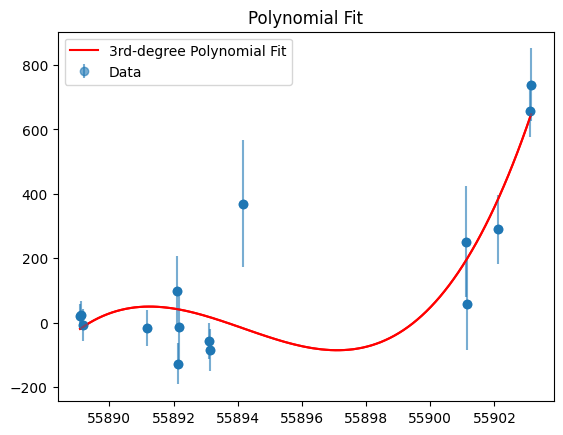

In [52]:
x_fit =  np.linspace(min(x), max(x), 100) #Generate x-values for plotting
y_fit_poly =  np.polyfit(x,y,3) # Fitting 3rd degree polynomial to the data

y_plot = np.polyval(y_fit_poly, x_fit)  # Evaluate polynomial at each x point
plt.scatter(x, y)  # Plot original data
plt.plot(x_fit, y_plot, 'r-')  # Plot the polynomial fit

plt.errorbar(x, y, yerr=dy, fmt='o', label='Data', alpha=0.6)
plt.plot(x_fit, y_plot, 'r-', label='3rd-degree Polynomial Fit')
plt.title('Polynomial Fit')
plt.legend()

Don't spend too much time on this. I could not get it to give a reasonable result.

## Try a Gaussian Process
We are using a package called `george` to make Gaussian process regression easier. It has all of the functions you need build in.

First we need to initialize a kernel (`george.kernels`). You should normalize the kernel by the total variance of the data points. Think about what hyperparameters would be appropriate for fitting your data. We can always optimize them later.

In [53]:
kernel =  np.var(y) * george.kernels.ExpSquaredKernel(0.5) 

Initialize a Gaussian process with the kernel you chose. This is all contained within the `george.GP` object, which we will use for the remainder of the calculations.

In [54]:
gp =  george.GP(kernel)

The first step is to precompute the covariance matrix at the observed times.

In [55]:
gp.compute(x,dy)

The second and last step is to use the Gaussian process to predict the light curve at the times in `x_fit`, given the observed data points in `y`. This should give you an interpolation **and** and uncertainty on the interpolation.

In [59]:
x_pred = np.linspace(min(x), max(x), 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)
pred_std = np.sqrt(pred_var)

Plot the results of your Gaussian process fit and compare to the data and the polynomial fit. Hint: display the uncertainties using `plt.fill_between`.

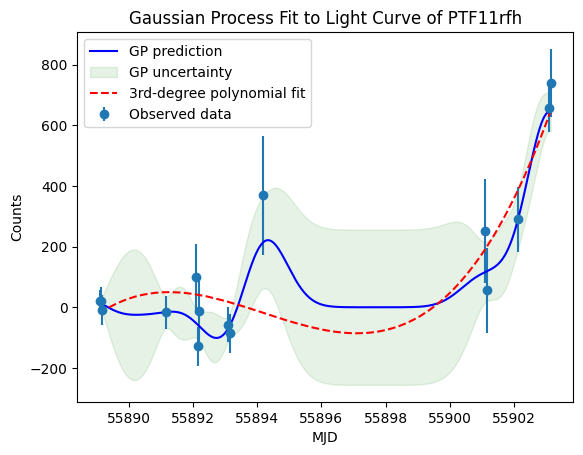

In [69]:
plt.errorbar(x, y, yerr=dy, fmt='o', label='Observed data')
plt.plot(x_pred, pred, 'b-', label='GP prediction')
plt.fill_between(x_pred, pred - pred_std, pred + pred_std, color='green', alpha=0.1, label='GP uncertainty')
plt.plot(x_pred, y_poly, 'r--', label='3rd-degree polynomial fit')
plt.xlabel('MJD')
plt.ylabel('Counts')
plt.title('Gaussian Process Fit to Light Curve of PTF11rfh')
plt.legend()

Once you get a reasonable fit, try adjusting the kernel and/or hyperparameters to see what effects they have.

## Take-Away Message
Gaussian process regression is a very easy and powerful way to interpolate an arbitrary set of data points with a nonparametric function. Furthermore, it gives you uncertainties on the interpolation and handles covariance between points correctly.

## Other Things to Try (Optional)
- Optimize the Gaussian process using the technique described in the George tutorial: https://george.readthedocs.io/en/latest/tutorials/first/.
- Marginalize over the hyperparameter(s) using MCMC.
- Try products of different kernels to see if you can get a better fit.